In [1]:
import os
import cv2
import pandas as pd
import pickle
import gzip
from time import time
from pyspark.sql import SparkSession
from pyspark.sql.functions import pandas_udf, PandasUDFType
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

2024-06-09 15:19:04.237662: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
clinical_data_path = '/Users/meev/Desktop/DBC_MRI/Clinical_and_Other_Features.xlsx'
features_path = '/Users/meev/Desktop/DBC_MRI/features_without_pyspark.pkl.gz'

In [3]:
clinical_data = pd.read_excel(clinical_data_path)

# Rename columns for consistency
clinical_data.columns = [col.replace(' ', '_') for col in clinical_data.columns]
clinical_data = clinical_data.rename(columns={'Patient_ID': 'patient_id', 'Pathologic_Response_to_Neoadjuvant_Therapy': 'response'})

# Convert 'Breast_MRI_001' to '001' in the patient_id column
clinical_data['patient_id'] = clinical_data['patient_id'].apply(lambda x: x.split('_')[-1] if isinstance(x, str) else x)

# Convert response to binary: 1 or 2 means response, anything other than 1 or 2 means no response
clinical_data['response'] = clinical_data['response'].apply(lambda x: 1 if x in [1, 2] else 0)



In [4]:
clinical_data

,patient_id,Date_of_Birth_(Days),Menopause_(at_diagnosis),Race_and_Ethnicity,ER,PR,HER2,Mol_Subtype,Staging_Nodes,Staging,Multifocal,Contralateral_Breast_Involvement,Lymphadenopathy_or_Suspicious_Nodes,Skin_Invovlement,response
0,001,-15209,0,2,0,0,1,2,1,0,0,0,0,0,0
1,002,-14061,0,2,0,0,0,3,0,0,0,0,0,0,1
2,005,-13932,0,5,1,0,1,1,1,0,1,0,1,0,1
3,009,-20541,1,1,0,0,0,3,0,0,1,0,0,0,1
4,010,-24712,1,1,0,0,0,3,2,0,1,0,1,0,0
5,012,-15885,0,2,0,0,0,3,2,-1,1,0,1,1,0
6,019,-13100,0,1,1,1,0,0,1,-1,1,0,0,0,0
7,021,-15855,1,1,1,1,0,0,1,-1,1,0,1,0,0
8,022,-19510,1,1,1,1,1,1,0,0,1,0,0,0,0
9,028,-15304,0,1,0,0,0,3,1,-1,0,0,1,1,0


In [5]:
# Load the features from the compressed file

with gzip.open(features_path, 'rb') as f:
    features_without_pyspark = pickle.load(f)

# Extract patient IDs from the keys
features_data = {
    'patient_id': [key.split('-')[0] for key in features_without_pyspark.keys()],
    **{f'feature_{i}': [features_without_pyspark[key][i] for key in features_without_pyspark.keys()] 
       for i in range(len(next(iter(features_without_pyspark.values()))))}
}

# Create a DataFrame for the features
features_df = pd.DataFrame(features_data)

In [6]:
# Ensure 'patient_id' columns are of the same type
features_df['patient_id'] = features_df['patient_id'].astype(str)
clinical_data['patient_id'] = clinical_data['patient_id'].astype(str)

# Combine extracted features with clinical data
combined_df = clinical_data.merge(features_df, on='patient_id', how='left')

# Check the combined DataFrame
#print("Combined DataFrame head:")
#print(combined_df.head())

# Check the shape of the combined DataFrame
print(f"Combined DataFrame shape: {combined_df.shape}")

Combined DataFrame shape: (1250, 25103)


In [7]:
combined_df

,patient_id,Date_of_Birth_(Days),Menopause_(at_diagnosis),Race_and_Ethnicity,ER,PR,HER2,Mol_Subtype,Staging_Nodes,Staging,...,feature_25078,feature_25079,feature_25080,feature_25081,feature_25082,feature_25083,feature_25084,feature_25085,feature_25086,feature_25087
0,001,-15209,0,2,0,0,1,2,1,0,...,0.000000,0.0,0.0,12.041177,0.0,0.0,0.000000,0.0,0.0,0.0
1,001,-15209,0,2,0,0,1,2,1,0,...,0.000000,0.0,0.0,12.304656,0.0,0.0,2.396533,0.0,0.0,0.0
2,001,-15209,0,2,0,0,1,2,1,0,...,0.000000,0.0,0.0,12.203288,0.0,0.0,1.850463,0.0,0.0,0.0
3,001,-15209,0,2,0,0,1,2,1,0,...,0.000000,0.0,0.0,0.045974,0.0,0.0,0.000000,0.0,0.0,0.0
4,001,-15209,0,2,0,0,1,2,1,0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1245,099,-25234,1,1,0,0,0,3,0,0,...,6.559295,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
1246,099,-25234,1,1,0,0,0,3,0,0,...,6.409789,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
1247,099,-25234,1,1,0,0,0,3,0,0,...,7.756427,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
1248,099,-25234,1,1,0,0,0,3,0,0,...,8.677382,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0


With Pyspark


In [8]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [9]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("SparkML") \
    .config("spark.executor.memory", "6g") \
    .config("spark.driver.memory", "6g") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/09 15:19:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [10]:
import pandas as pd
import gzip
import pickle
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Separate features and target
X = combined_df.drop(columns=['patient_id', 'response'])
y = combined_df['response']

# Perform PCA
pca = PCA(n_components=35)  # Adjust the number of components as needed
X_pca = pca.fit_transform(X)

# Create a new DataFrame with the reduced features
pca_columns = [f'pca_{i}' for i in range(X_pca.shape[1])]
pca_df = pd.DataFrame(X_pca, columns=pca_columns)
pca_df['response'] = y.values


In [11]:
pca_df.shape

(1250, 36)

In [12]:
# Convert the reduced DataFrame to a Spark DataFrame
spark_combined_df = spark.createDataFrame(pca_df)

Logistic Regression validation accuracy: 0.9751
Logistic Regression test accuracy: 0.9737
Logistic Regression precision: 0.9742
Logistic Regression recall: 0.9737
Logistic Regression F1 score: 0.9735
Logistic Regression AUROC: 0.9988
Logistic Regression training time: 48.9061 seconds
Best parameters for Logistic Regression:
  regParam: 0.05
  elasticNetParam: 0.2


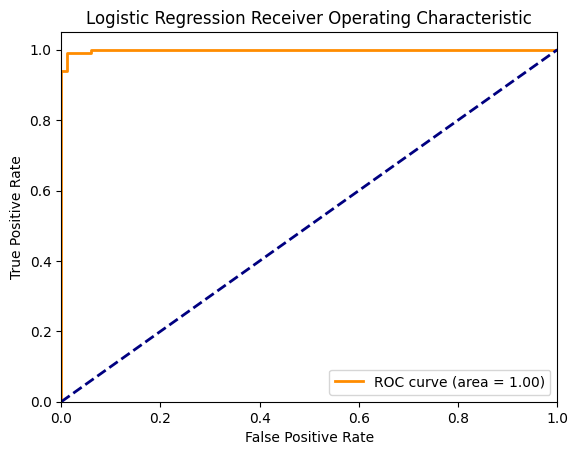

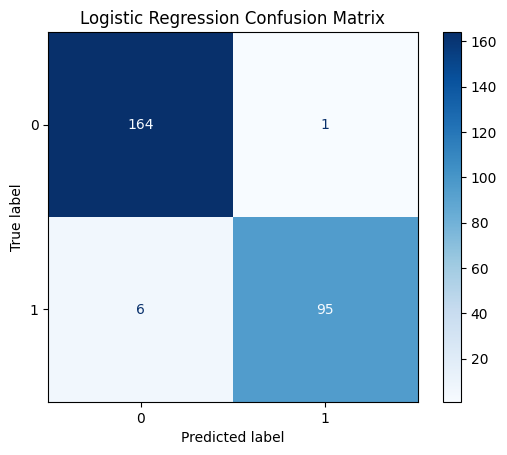

True Positives: 95
False Positives: 1
True Negatives: 164
False Negatives: 6
Random Forest validation accuracy: 0.9657
Random Forest test accuracy: 0.9549
Random Forest precision: 0.9579
Random Forest recall: 0.9549
Random Forest F1 score: 0.9543
Random Forest AUROC: 0.9999
Random Forest training time: 16.8025 seconds
Best parameters for Random Forest:
  numTrees: 90
  maxDepth: 3


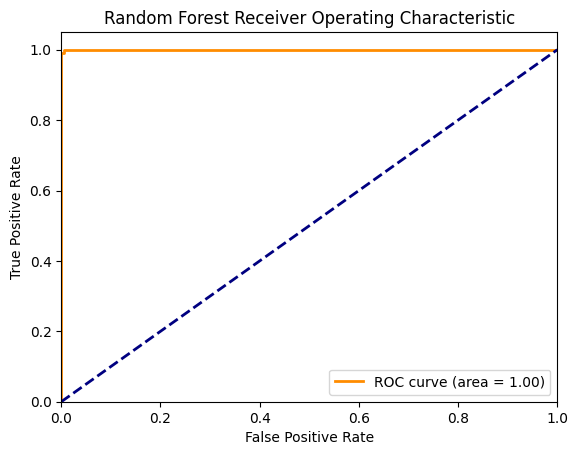

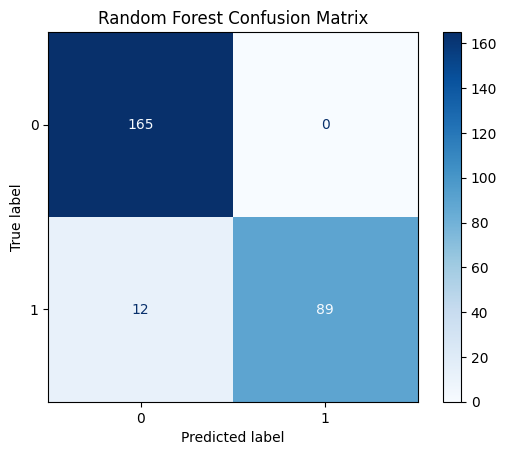

True Positives: 89
False Positives: 0
True Negatives: 165
False Negatives: 12
Gradient Boosted Trees validation accuracy: 0.9813
Gradient Boosted Trees test accuracy: 0.9850
Gradient Boosted Trees precision: 0.9850
Gradient Boosted Trees recall: 0.9850
Gradient Boosted Trees F1 score: 0.9849
Gradient Boosted Trees AUROC: 0.9992
Gradient Boosted Trees training time: 43.4511 seconds
Best parameters for Gradient Boosted Trees:
  maxIter: 20
  maxDepth: 3


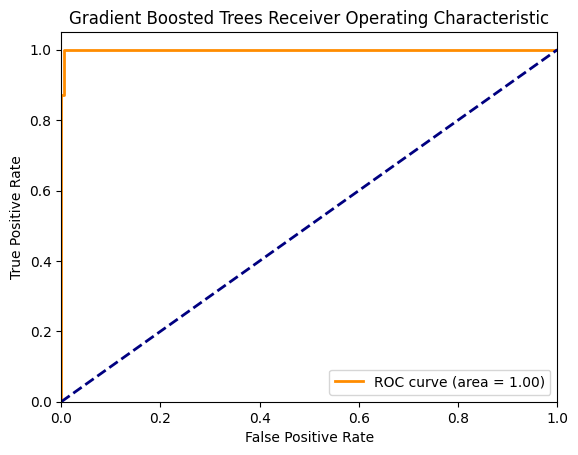

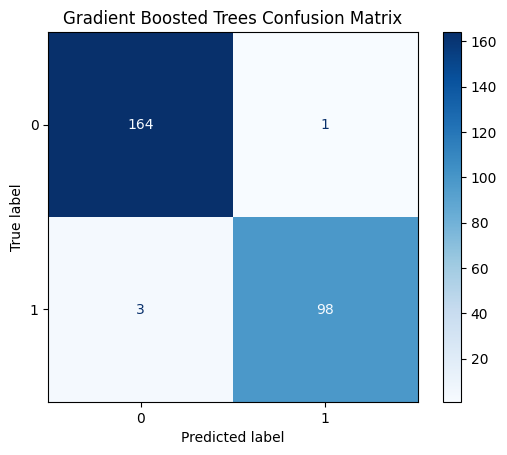

True Positives: 98
False Positives: 1
True Negatives: 164
False Negatives: 3
Support Vector Machine validation accuracy: 0.9502
Support Vector Machine test accuracy: 0.9511
Support Vector Machine precision: 0.9535
Support Vector Machine recall: 0.9511
Support Vector Machine F1 score: 0.9505
Support Vector Machine AUROC: 0.9926
Support Vector Machine training time: 88.3228 seconds
Best parameters for Support Vector Machine:
  regParam: 0.7


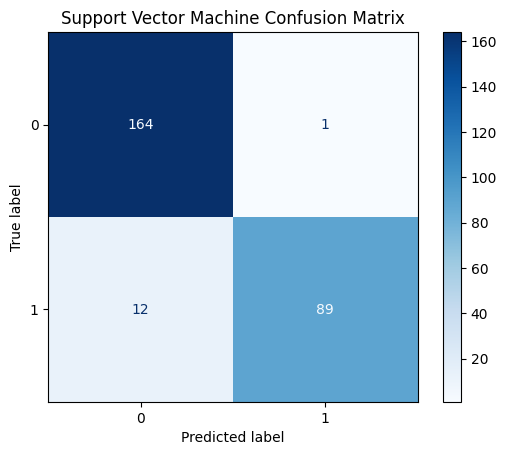

True Positives: 89
False Positives: 1
True Negatives: 164
False Negatives: 12


LinearSVCModel: uid=LinearSVC_41652c2ef87e, numClasses=2, numFeatures=35

In [13]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import numpy as np
import time

# Verify the loaded data
# spark_combined_df.show(5)

# Assemble the features into a single vector
assembler = VectorAssembler(inputCols=[col for col in spark_combined_df.columns if col != 'response'],
                            outputCol="features")
assembled_df = assembler.transform(spark_combined_df)

# Select only the necessary columns
final_df = assembled_df.select('features', 'response')

# Split the data into training, validation, and test sets
train_df, temp_df = final_df.randomSplit([0.5, 0.5], seed=22)
val_df, test_df = temp_df.randomSplit([0.5, 0.5], seed=22)

def plot_auroc(test_predictions, model_name):
    # Extract prediction probabilities and true labels
    y_true = test_predictions.select('response').collect()
    y_scores = test_predictions.select('probability').collect()
    
    # Convert to numpy arrays for sklearn
    y_true = np.array([float(row.response) for row in y_true])
    y_scores = np.array([row.probability[1] for row in y_scores])  # probability of class 1

    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(test_predictions, model_name):
    # Extract true labels and predictions
    y_true = test_predictions.select('response').collect()
    y_pred = test_predictions.select('prediction').collect()

    # Convert to numpy arrays for sklearn
    y_true = np.array([float(row.response) for row in y_true])
    y_pred = np.array([float(row.prediction) for row in y_pred])

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

    # Print true positive, false positive, true negative, false negative counts
    tn, fp, fn, tp = cm.ravel()
    print(f"True Positives: {tp}")
    print(f"False Positives: {fp}")
    print(f"True Negatives: {tn}")
    print(f"False Negatives: {fn}")

def print_best_params(cv_model, param_grid, model_name):
    best_model = cv_model.bestModel
    best_params = {}
    for param in param_grid[0].keys():
        best_params[param.name] = best_model.extractParamMap()[param]
    
    print(f"Best parameters for {model_name}:")
    for param, value in best_params.items():
        print(f"  {param}: {value}")

def train_and_evaluate(model, param_grid, train_df, val_df, test_df, model_name):
    # Cross-validator setup
    evaluator = MulticlassClassificationEvaluator(labelCol="response", predictionCol="prediction", metricName="accuracy")
    crossval = CrossValidator(estimator=model, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3)

    # Train the model
    start_time = time.time()
    cv_model = crossval.fit(train_df)
    end_time = time.time()
    training_time = end_time - start_time

    # Get the best model
    best_model = cv_model.bestModel

    # Evaluate on validation set
    val_predictions = best_model.transform(val_df)
    val_accuracy = evaluator.evaluate(val_predictions)

    # Evaluate on test set
    test_predictions = best_model.transform(test_df)
    test_accuracy = evaluator.evaluate(test_predictions)

    # Additional metrics
    evaluator_precision = MulticlassClassificationEvaluator(labelCol="response", predictionCol="prediction", metricName="weightedPrecision")
    evaluator_recall = MulticlassClassificationEvaluator(labelCol="response", predictionCol="prediction", metricName="weightedRecall")
    evaluator_f1 = MulticlassClassificationEvaluator(labelCol="response", predictionCol="prediction", metricName="f1")
    evaluator_auroc = BinaryClassificationEvaluator(labelCol="response", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

    precision = evaluator_precision.evaluate(test_predictions)
    recall = evaluator_recall.evaluate(test_predictions)
    f1 = evaluator_f1.evaluate(test_predictions)
    auroc = evaluator_auroc.evaluate(test_predictions)

    print(f"{model_name} validation accuracy: {val_accuracy:.4f}")
    print(f"{model_name} test accuracy: {test_accuracy:.4f}")
    print(f"{model_name} precision: {precision:.4f}")
    print(f"{model_name} recall: {recall:.4f}")
    print(f"{model_name} F1 score: {f1:.4f}")
    print(f"{model_name} AUROC: {auroc:.4f}")
    print(f"{model_name} training time: {training_time:.4f} seconds")

    # Print best parameters
    print_best_params(cv_model, param_grid, model_name)

    # Plot AUROC only if the model has a probability column
    if 'probability' in test_predictions.columns:
        plot_auroc(test_predictions, model_name)

    # Plot confusion matrix
    plot_confusion_matrix(test_predictions, model_name)

    return best_model

# Logistic Regression with regularization and hyperparameter tuning
lr = LogisticRegression(labelCol="response", featuresCol="features", maxIter=100)
param_grid_lr = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.05, 0.1]) \
    .addGrid(lr.elasticNetParam, [0.2]) \
    .build()
train_and_evaluate(lr, param_grid_lr, train_df, val_df, test_df, "Logistic Regression")

# Random Forest with parameter tuning
rf = RandomForestClassifier(labelCol="response", featuresCol="features")
param_grid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees, [90]) \
    .addGrid(rf.maxDepth, [3]) \
    .build()
train_and_evaluate(rf, param_grid_rf, train_df, val_df, test_df, "Random Forest")

# Gradient Boosted Trees with parameter tuning
gbt = GBTClassifier(labelCol="response", featuresCol="features")
param_grid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [20]) \
    .addGrid(gbt.maxDepth, [3]) \
    .build()
train_and_evaluate(gbt, param_grid_gbt, train_df, val_df, test_df, "Gradient Boosted Trees")

# Support Vector Machine with regularization and hyperparameter tuning
svm = LinearSVC(labelCol="response", featuresCol="features")
param_grid_svm = ParamGridBuilder() \
    .addGrid(svm.regParam, [0.7]) \
    .build()
train_and_evaluate(svm, param_grid_svm, train_df, val_df, test_df, "Support Vector Machine")


In [14]:
spark.stop()